In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download ananthu017/emotion-detection-fer

 71% 46.0M/65.2M [00:00<00:00, 249MB/s]
100% 65.2M/65.2M [00:00<00:00, 165MB/s]


In [6]:
! unzip emotion-detection-fer.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,Flatten
from keras import models
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [8]:
tf.keras.__version__

'2.12.0'

In [9]:
img_size=48
channal=1
batch_size=32

In [10]:
train=tf.keras.preprocessing.image_dataset_from_directory("train",batch_size=batch_size,color_mode='grayscale',image_size=(48, 48))
test=tf.keras.preprocessing.image_dataset_from_directory("test",batch_size=batch_size,color_mode='grayscale',image_size=(48, 48))

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [11]:
train.class_names

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [12]:
test.class_names

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [13]:
class_name=train.class_names
n_class=len(class_name)

In [14]:
for image_batch, label_batch in train.take(1):
    print(image_batch[0].shape)
    print(label_batch.numpy())

(48, 48, 1)
[0 5 3 6 3 0 5 2 6 5 6 6 6 0 0 6 0 3 4 2 5 0 3 3 3 3 6 2 4 3 0 2]


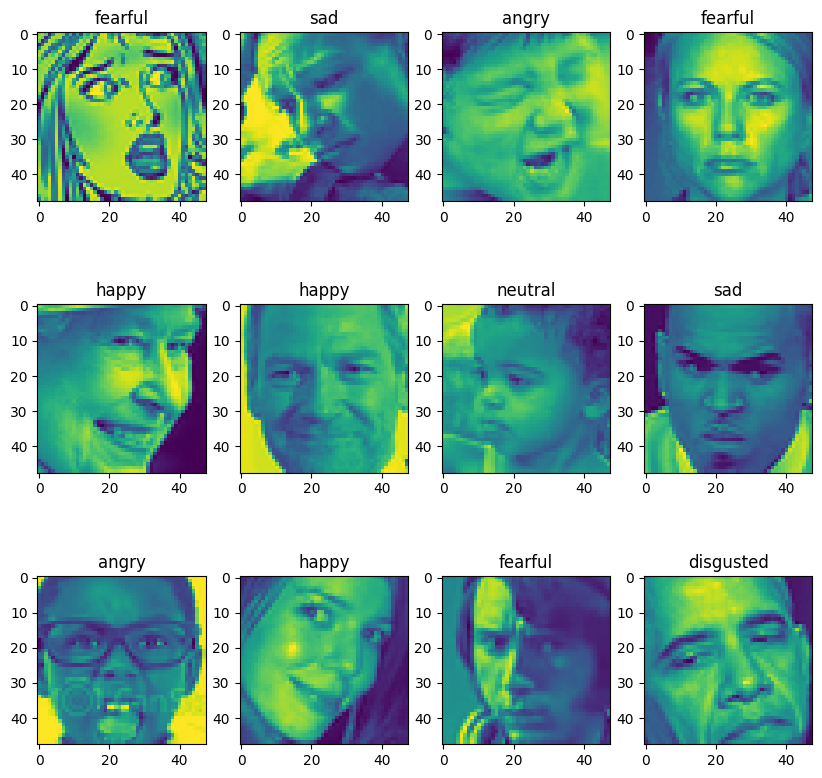

In [15]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])

In [16]:
len(train)

898

In [17]:
type(train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [18]:
898*32

28736

In [19]:
len(test)

225

In [20]:
898+225

1123

In [21]:
def split_val_test(test_df):
    val_data=test_df.take(112)
    test_data=test_df.skip(112)
    return val_data, test_data

In [22]:
val_data,test_data=split_val_test(test)

In [23]:
len(val_data),len(test_data)

(112, 113)

In [24]:
val_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
test_data

<_SkipDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
resize_and_rescale=tf.keras.Sequential([layers.experimental.preprocessing.Resizing(48,48),
                                       layers.experimental.preprocessing.Rescaling(1.0/255)])

```data_augumentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                       layers.experimental.preprocessing.RandomRotation(0.2)])```

In [27]:
# Model1
"""model=models.Sequential([resize_and_rescale,
                       layers.Conv2D(filters=32,kernel_size=(3,3),
                                    activation="relu",input_shape=(48,48,1)),
                       layers.MaxPooling2D((2,2)),
                       layers.Conv2D(filters=32,kernel_size=(3,3),
                                    activation="relu"),
                       layers.MaxPooling2D((2,2)),
                       layers.Flatten(),
                       layers.Dense(64,activation="relu"),
                       layers.Dropout(0.2),
                       layers.Dense(32,activation="relu"),
                       layers.Dropout(0.2),
                       layers.Dense(n_class,activation="softmax") 
                       ])
model.build(input_shape=(32,48,48,1))"""

'model=models.Sequential([resize_and_rescale,\n                       layers.Conv2D(filters=32,kernel_size=(3,3),\n                                    activation="relu",input_shape=(48,48,1)),\n                       layers.MaxPooling2D((2,2)),\n                       layers.Conv2D(filters=32,kernel_size=(3,3),\n                                    activation="relu"),\n                       layers.MaxPooling2D((2,2)),\n                       layers.Flatten(),\n                       layers.Dense(64,activation="relu"),\n                       layers.Dropout(0.2),\n                       layers.Dense(32,activation="relu"),\n                       layers.Dropout(0.2),\n                       layers.Dense(n_class,activation="softmax") \n                       ])\nmodel.build(input_shape=(32,48,48,1))'

In [28]:
# Model2
model=models.Sequential([resize_and_rescale,
                       layers.Conv2D(32, kernel_size=(3, 3), padding='same', 
                                     activation='relu', input_shape=(48, 48,1)),
                       layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
                       layers.BatchNormalization(),
                       layers.MaxPool2D(pool_size=(2, 2)),
                       layers.Dropout(0.25),
                       layers.Conv2D(128,(5,5), padding='same', activation='relu'),
                       layers.BatchNormalization(),
                       layers.MaxPool2D(pool_size=(2, 2)),
                       layers.Dropout(0.25),
                       layers.Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
                       layers.BatchNormalization(),
                       layers.MaxPool2D(pool_size=(2, 2)),
                       layers.Dropout(0.25),
                       layers.Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
                       layers.BatchNormalization(),
                       layers.MaxPool2D(pool_size=(2, 2)),
                       layers.Dropout(0.3),
                       layers.Flatten(), 
                       layers.Dense(256,activation = 'relu'),
                       layers.BatchNormalization(),
                       layers.Dropout(0.25),
    
                       layers.Dense(512,activation = 'relu'),
                       layers.BatchNormalization(),
                       layers.Dropout(0.3),

                       layers.Dense(n_class, activation='softmax'),
                         
                       ])
model.build(input_shape=(32,48,48,1))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 48, 48, 1)           0         
                                                                 
 conv2d (Conv2D)             (32, 48, 48, 32)          320       
                                                                 
 conv2d_1 (Conv2D)           (32, 48, 48, 64)          18496     
                                                                 
 batch_normalization (BatchN  (32, 48, 48, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 24, 24, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 24, 24, 64)         

In [30]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [31]:
Epoch=50
history=model.fit(train,epochs=Epoch,
         batch_size=64,
         verbose=1,
         validation_data=val_data)

Epoch 1/50
898/898 [==============================] - 37s 24ms/step - loss: 8.9971 - accuracy: 0.2075 - val_loss: 7.8173 - val_accuracy: 0.2921
Epoch 2/50
898/898 [==============================] - 22s 24ms/step - loss: 7.2578 - accuracy: 0.2620 - val_loss: 6.1563 - val_accuracy: 0.3398
Epoch 3/50
898/898 [==============================] - 22s 24ms/step - loss: 5.5845 - accuracy: 0.3185 - val_loss: 4.7100 - val_accuracy: 0.3870
Epoch 4/50
898/898 [==============================] - 21s 24ms/step - loss: 4.2682 - accuracy: 0.3647 - val_loss: 3.5975 - val_accuracy: 0.4395
Epoch 5/50
898/898 [==============================] - 21s 24ms/step - loss: 3.3424 - accuracy: 0.4137 - val_loss: 2.9384 - val_accuracy: 0.4562
Epoch 6/50
898/898 [==============================] - 21s 24ms/step - loss: 2.7313 - accuracy: 0.4580 - val_loss: 2.3837 - val_accuracy: 0.5017
Epoch 7/50
898/898 [==============================] - 21s 24ms/step - loss: 2.3173 - accuracy: 0.4896 - val_loss: 2.2045 - val_accuracy:

In [32]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss= history.history["loss"]
val_loss=history.history["val_loss"]

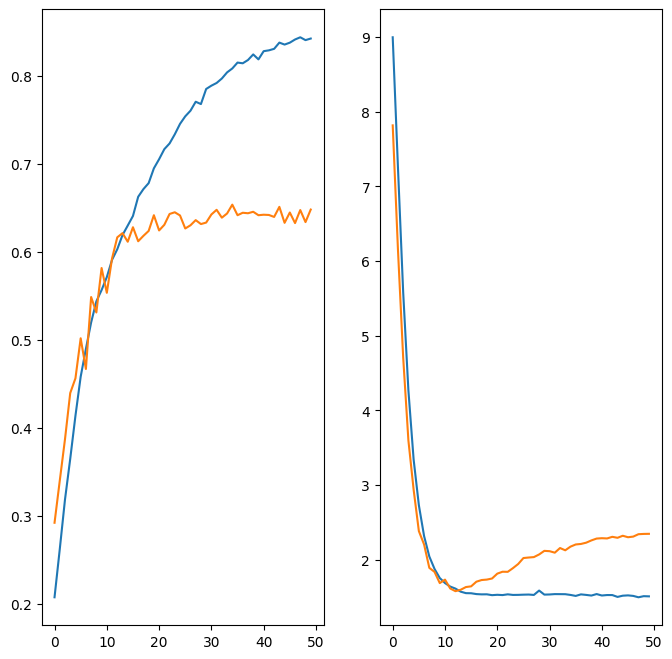

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epoch),acc,label="Training Accuracy")
plt.plot(range(Epoch),val_acc,label="Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(Epoch),loss,label="Training loss")
plt.plot(range(Epoch),val_loss,label="Validation loss")

plt.show()

First image to predict
Actual Label:  angry
Predicted Label:  neutral


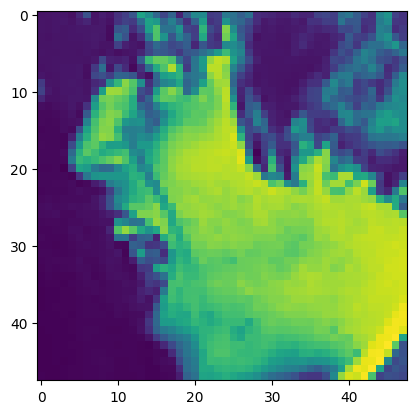

In [35]:
for image_batch,label_batch in test_data.take(1):
    first_image=image_batch[0]
    first_label=label_batch[0]
    print("First image to predict")
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    print("Actual Label: ", class_name[first_label])
    batch_prediction=model.predict(image_batch,verbose=0)
    print("Predicted Label: ",class_name[np.argmax(batch_prediction[0])])

In [36]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array=tf.expand_dims(img_array,0)
    prediction=model.predict(img_array,verbose=0)
    predicted_class=class_name[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    return predicted_class, confidence

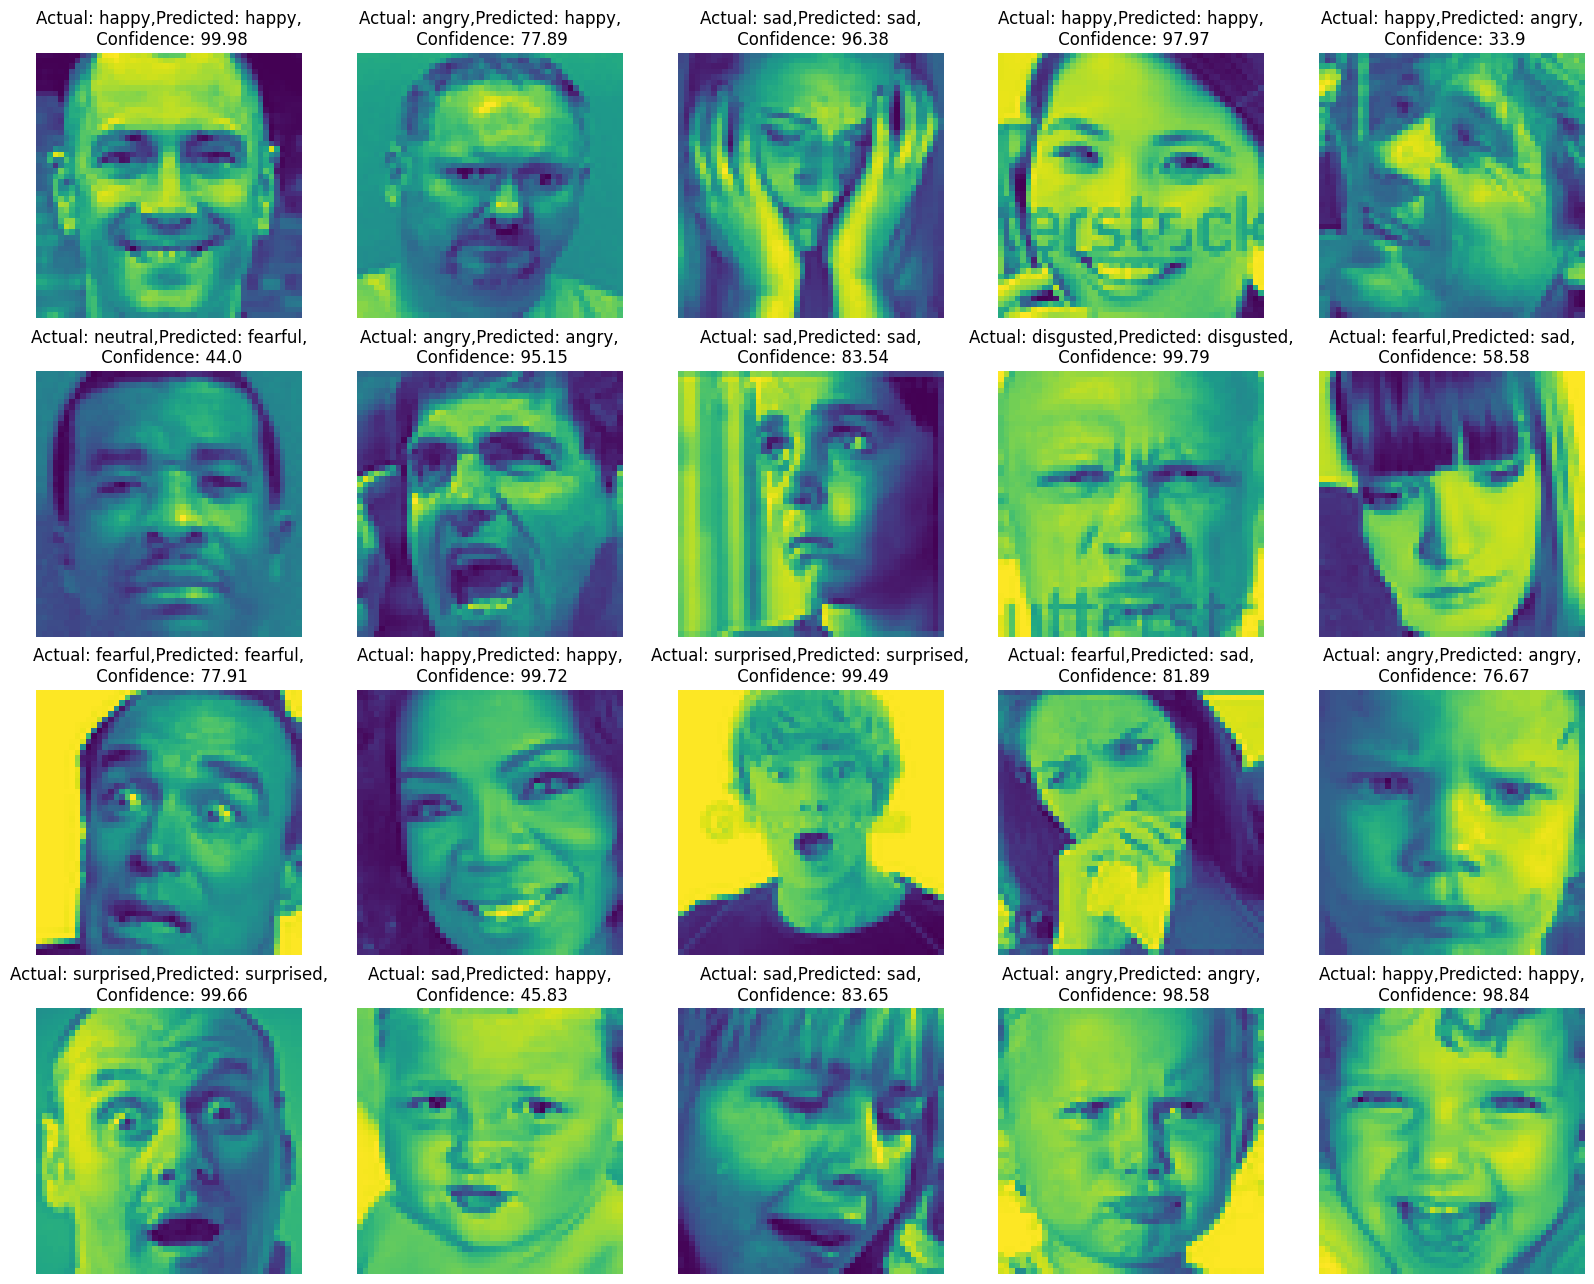

In [37]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in test_data.take(1):
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        predicted_class, confidence=predict(model,image_batch[i])
        actual_class=class_name[label_batch[i]]
        plt.title(f"Actual: {actual_class},Predicted: {predicted_class},\n Confidence: {confidence}")

In [ ]:
import os
model_name=max([int(i) for i in os.listdir("saved_model/")+[0]])+1
model.save(f"saved_model/{model_name}")

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


In [49]:
import os

model.save("2")

In [53]:
!zip -r /content/2.zip /content/2

  adding: content/2/ (stored 0%)
  adding: content/2/keras_metadata.pb (deflated 94%)
  adding: content/2/fingerprint.pb (stored 0%)
  adding: content/2/saved_model.pb (deflated 89%)
  adding: content/2/assets/ (stored 0%)
  adding: content/2/variables/ (stored 0%)
  adding: content/2/variables/variables.index (deflated 72%)
  adding: content/2/variables/variables.data-00000-of-00001 (deflated 8%)


In [54]:
from google.colab import files
files.download('/content/2.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>